# Set Up Spark Environment

In [1]:
import os

In [2]:
packages = "com.crealytics:spark-excel_2.11:0.13.1"

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages {0} pyspark-shell".format(packages)
)

In [3]:
# Use a specific Spark Version. In this case 2.3.4
import findspark
findspark.init('')

In [4]:
import pyspark
from pyspark.sql import functions as F, SparkSession, Window
from pyspark.ml.feature import VectorAssembler

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, date, timedelta
from dateutil import relativedelta

from pyspark.sql import SparkSession, SQLContext, Row, DataFrame
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark import SparkConf, SparkContext
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


import emoji
import regex
import re

In [6]:
# Start PyPark Session
spark = SparkSession\
        .builder\
        .config("spark.driver.memory", "15g") \
        .config("spark.driver.maxResultSize", "3g")\
        .appName('HomeWork2')\
        .getOrCreate()

In [7]:
# How much memory do we have?
print(spark.conf.get('spark.driver.memory'))
print(spark.conf.get('spark.driver.maxResultSize'))

15g
3g


In [8]:
spark_context = spark.sparkContext
sql_context = SQLContext(spark_context)

# Read in the Data

In [9]:
#read in venmo data sample
venmo_df = sql_context.read.parquet('VenmoSample.snappy.parquet')\
          .repartition(F.col("user1")).cache()

In [10]:
venmo_df.show(25)

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|3891364|5452142|         payment|2016-01-30 03:02:17|Bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|
|4136881|1074970|         payment|2016-06-21 21:36:19|                🍕❤️|      false|5769b35323e064eac...|
|1841732|2900826|         payment|2016-06-29 13:13:16|            🍇🍌🍓🍹|      false|5773c96c23e064eac...|
|2281658|1429548|         payment|2015-08-07 04:41:17|             🚙✊🏻💦|      false|55c436ed1a624b17e...|
| 204908| 234866|         payment|2015-04-05 04:07:43|         Sushi samba|      false|5520b50fe855742e2...|
|1029768|1543181|         payment|2016-04-15 06:10:49|              🍸🍸🍸|      false|571085e9cd03c9af2...|
| 378749| 385029|         payment

In [11]:
#read in emoji dictionary
emoji_dict = sql_context.read \
                        .option('inferSchema','true') \
                        .option('header','true') \
                        .csv('Venmo_Emoji_Classification_Dictionary.csv')

In [12]:
emoji_dict.show(15)

+-----+------+----+--------+--------------+------+-------+
|Event|Travel|Food|Activity|Transportation|People|Utility|
+-----+------+----+--------+--------------+------+-------+
| 🇦🇺|    🏔|  🍇|      👾|            🚄|    😀|      ⚡|
| 🇫🇷|     ⛰|  🍈|      🕴|            🚅|    😃|     💡|
|   🎂|    🌋|  🍉|      🎪|            🚆|    😄|     🔌|
|   🛍|    🗻|  🍊|      🎭|            🚇|    😁|     📺|
| 🇨🇦|    🏕|  🍋|      🎨|            🚈|    😆|     🔌|
| 🇧🇷|    🏖|  🍌|      🎰|            🚉|    😅|      ⚡|
|   🐉|    🏜|  🍍|      🚣|            🚊|    🤣|     💡|
|   🎅|    🏝|  🍎|      🛀|            🚝|    😂|     💸|
| 🇲🇽|    🏞|  🍏|      🎗|            🚞|    🙂|     💦|
| 🇨🇳|    🏟|  🍐|      🎟|            🚋|   🙃-|     💧|
|   🐰|    🏛|  🍑|      🎫|            🚌|    😉|     📱|
|   🎥|    🏗|  🍒|      🎖|            🚍|    😊|     🏢|
|   🍂|    🏘|  🍓|      🏆|            🚎|    😇|     🏣|
|   👨|    🏙|  🍅|      🏅|            🚏|    🥰|     🔥|
|   💪|    🏚|  🍆|       ⚽|            🚐|   😍-|   null|
+-----+------+----+--------+--------------+-

In [13]:
# Read com Excel File
word_dict = spark.read\
    .format("com.crealytics.spark.excel")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("Venmo Word Classification Dictonary BAX-423.xlsx").drop("_c9")

In [14]:
word_dict.show(10)

+----------+---------+------------+--------+-------+---------------+-----------+-------+----------------+
|   People |    Food |      Event |Activity|Travel |Transportation |   Utility |   Cash|Illegal/Sarcasm |
+----------+---------+------------+--------+-------+---------------+-----------+-------+----------------+
|    friend|     food|    birthday|    ball|  beach|           lyft|       bill|   atm |       addiction|
|friendship|      bbq|   christmas|    boat|  place|           uber|      cable|  bank |            drug|
|      baby|     bean|       happy|     bar|     la|            cab|        fee|  cash |           wangs|
|       boy|    latte|        bday|    book|  world|            bus|   electric|  money|            weed|
|      girl|breakfast|     wedding|    club|  hotel|            car|electricity|   buck|            anal|
|      help|   brunch|        xmas|    card|   trip|            gas|   internet| wallet|              bj|
|      like|   burger|     holiday|   dance|  

In [15]:
word_dict = word_dict.withColumnRenamed("People ","People") \
            .withColumnRenamed("Event ","Event")\
            .withColumnRenamed("Food ","Food")\
            .withColumnRenamed("Travel ","Travel")\
            .withColumnRenamed("Transportation ","Transportation")\
            .withColumnRenamed("Utility ","Utility")\
            .withColumnRenamed("Illegal/Sarcasm ","Illegal_Sarcasm")

# Classify Venmo’s transactions

## Step 1:
"Unpivot" the data, so that we have one column with the categories and one column with the words/emojis.

In [16]:
#make emoji table of definitions into table for easy SQL
emoji_dict.createOrReplaceTempView('emoji_table')

In [21]:
#'unpivot' the data
emoji_table_transformed = spark.sql("""
SELECT 'Event' as category, Event as word
FROM emoji_table
UNION
SELECT 'Travel' as category, Travel as word
FROM emoji_table
UNION
SELECT 'Food' as category, Food as word
FROM emoji_table
UNION
SELECT 'Activity' as category, Activity as word
FROM emoji_table
UNION
SELECT 'Transportation' as category, Transportation as word
FROM emoji_table
UNION
SELECT 'People' as category, People as word
FROM emoji_table
UNION
SELECT 'Utility' as category, Utility as word
FROM emoji_table
""")

In [22]:
#define function that extract only words
def clear_emoji(string):
    temp_string = string
    for letter in string:
        if letter not in emoji.UNICODE_EMOJI and letter !='\u200d':
            temp_string = temp_string.replace(letter,'')
    return temp_string

clear_emoji_udf = udf(lambda x: clear_emoji(x), StringType())

In [23]:
emoji_table_clean = emoji_table_transformed\
            .withColumnRenamed('word', 'word2')\
            .withColumn('word', clear_emoji_udf("word2")).drop('word2')\
            .filter(emoji_table_transformed.word != '🧜‍♀️')   # kill the mermaid

In [24]:
emoji_table_clean.show(10)

+--------------+--------+
|      category|    word|
+--------------+--------+
|        Travel|      🚃|
|Transportation|      🚖|
|Transportation|       ⚓|
|        People|👨‍👧‍👧|
|        Travel|      🏬|
|          Food|      🍟|
|          Food|      🍘|
|        People|      😛|
|        People|      🤮|
|        People|      🤞|
+--------------+--------+
only showing top 10 rows



In [25]:
#make word table of definitions into table for easy SQL
word_dict.createOrReplaceTempView('word_table')

In [26]:
#'unpivot' the data
word_table_transformed = spark.sql("""
  SELECT 'People' as category, People as word
  FROM word_table
  UNION
  SELECT 'Food' as category, Food as word
  FROM word_table
  UNION
  SELECT 'Event' as category, Event as word
  FROM word_table
  UNION
  SELECT 'Activity' as category, Activity as word
  FROM word_table
  UNION
  SELECT 'Travel' as category, Travel as word
  FROM word_table
  UNION
  SELECT 'Transportation' as category, Transportation as word
  FROM word_table
  UNION
  SELECT 'Utility' as category, Utility as word
  FROM word_table
  UNION
  SELECT 'Cash' as category, Cash as word
  FROM word_table
  UNION
  SELECT 'IllegalSarcasm' as category, Illegal_Sarcasm as word
  FROM word_table
""")

In [27]:
word_table_transformed.show(20)

+--------------+----------+
|      category|      word|
+--------------+----------+
|          Food|     vegan|
|      Activity|     draft|
|      Activity|  survivor|
|        Travel|     tahoe|
|Transportation|       gas|
|        People|      girl|
|        People|        ya|
|          Food|       bun|
|         Event|     photo|
|IllegalSarcasm|      swag|
|          Food|     sugar|
|      Activity|volleyball|
|      Activity|       nfl|
|        Travel|      nola|
|          Food|      rice|
|Transportation|  carpool |
|      Activity|  activity|
|        Travel|     beach|
|       Utility|       pge|
|       Utility|   tmobile|
+--------------+----------+
only showing top 20 rows



In [28]:
#concatenate the two dictionaries into one
dictionary_complete = word_table_transformed.union(emoji_table_clean)
dictionary_complete = dictionary_complete.orderBy('category').repartition('category').cache()

expression_dictionary = dictionary_complete.toPandas()
expression_dictionary['word'] = expression_dictionary['word'].str.strip()
expression_dictionary['category'] = expression_dictionary['category'].str.strip()
expression_dictionary = expression_dictionary.set_index('word').to_dict()['category']

## Step 2:
Get category when a word or emoji is in the "description" field of the Venmo data

In [29]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

In [30]:
#add leading and trailing space to "description" column to make sure we can match to complete words
#even when there's only a one word/emoji description
venmo_df = venmo_df.withColumn('description', lower(col('description')))
#venmo_df = venmo_df.withColumn('description',concat(lit(' '),col('description'),lit(' ')))

#dictionary_complete = dictionary_complete.withColumn('word',concat(lit(' '),col('word'),lit(' ')))

#transform to tables for easy SQL
venmo_df.createOrReplaceTempView('venmo_table')
dictionary_complete.createOrReplaceTempView('dictionary_table')

In [31]:
#join the data by cross join -- creates a lot of rows, but makes it easier to find if the 'word' is in the 'description'
joined_data = spark.sql("""
SELECT *
FROM venmo_table
CROSS JOIN dictionary_table
""")

In [32]:
joined_data.show(10)

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------+------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|category|  word|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+--------+------+
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    Food| vegan|
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    Food|   bun|
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    Food| sugar|
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    Food|  rice|
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    Food|  mike|
|3891364|545214

In [33]:
#define function that puts the emojis from the descriptions into one string
import regex
def get_emojis(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    s = ' '
    emoji_string = s.join(emoji_list)
    
    return emoji_string

In [34]:
#define function that extract only words
def get_words(string):
    temp_string = string
    for letter in string:
        if letter in emoji.UNICODE_EMOJI or letter == '\u200d':
            temp_string = temp_string.replace(letter, '')
    return temp_string

In [35]:
#turn get_emojis function into a Spark UDF
get_emoji_udf = udf(lambda x: get_emojis(x), StringType())
get_words_udf = udf(lambda x: get_words(x), StringType())


#add emoji column and only select necessary columns
joined_data = venmo_df\
              .withColumn('emojis', get_emoji_udf('description'))\
              .withColumn('words', get_words_udf('description'))\
              .withColumn('words', F.trim(F.col("words")))


In [36]:
joined_data.show(10)

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----------+----------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|     emojis|           words|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----------+----------------+
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|   🎉 💞 🎉|bdayyy sundiego!|
|4136881|1074970|         payment|2016-06-21 21:36:19|                🍕❤️|      false|5769b35323e064eac...|      🍕 ❤️|               ️|
|1841732|2900826|         payment|2016-06-29 13:13:16|            🍇🍌🍓🍹|      false|5773c96c23e064eac...|🍇 🍌 🍓 🍹|                |
|2281658|1429548|         payment|2015-08-07 04:41:17|             🚙✊🏻💦|      false|55c436ed1a624b17e...|  🚙 ✊🏻 💦|                |
| 204908| 234866|         payment|2015-04-05 04:07:43|  

In [37]:
tokenizer_emoji = Tokenizer(inputCol="emojis", outputCol="token_emojis")
tokenizer_words = Tokenizer(inputCol="words", outputCol="token_words_dirt")
remover = StopWordsRemover(inputCol="token_words_dirt", outputCol="token_words")
### Should we remove punctuation marks?
pipeline = Pipeline(stages=[tokenizer_emoji, tokenizer_words, remover])

joined_data_token = pipeline.fit(joined_data).transform(joined_data)\
                    .drop('emojis', 'words', 'token_words_dirt')

In [38]:
joined_data_token.show(5)

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+----------------+-------------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|    token_emojis|        token_words|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+----------------+-------------------+
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    [🎉, 💞, 🎉]|[bdayyy, sundiego!]|
|4136881|1074970|         payment|2016-06-21 21:36:19|                🍕❤️|      false|5769b35323e064eac...|        [🍕, ❤️]|                [️]|
|1841732|2900826|         payment|2016-06-29 13:13:16|            🍇🍌🍓🍹|      false|5773c96c23e064eac...|[🍇, 🍌, 🍓, 🍹]|                 []|
|2281658|1429548|         payment|2015-08-07 04:41:17|             🚙✊🏻💦|      false|55c436ed1a624b17e...|   [🚙, ✊🏻, 💦]|                 []|


In [39]:
joined_data_token = joined_data_token.withColumn('tokens',
                             concat(coalesce(col("token_emojis"),array()),
                                    coalesce(col("token_words"), array())
                                   ))

In [40]:
joined_data_token.select('description', 'tokens').show(30)

+--------------------+--------------------+
|         description|              tokens|
+--------------------+--------------------+
|bdayyy🎉💞🎉 sund...|[🎉, 💞, 🎉, bday...|
|                🍕❤️|         [🍕, ❤️, ️]|
|            🍇🍌🍓🍹|  [🍇, 🍌, 🍓, 🍹, ]|
|             🚙✊🏻💦|     [🚙, ✊🏻, 💦, ]|
|         sushi samba|    [, sushi, samba]|
|              🍸🍸🍸|      [🍸, 🍸, 🍸, ]|
|         boat refund|    [, boat, refund]|
|    bc we can't stop|        [, bc, stop]|
|    february comcast|[, february, comc...|
|              🍹🍹🍹|      [🍹, 🍹, 🍹, ]|
|            stripper|        [, stripper]|
|                   ✈|               [✈, ]|
|        for the kids|            [, kids]|
|tahoe food and dr...|[, tahoe, food, d...|
|lyftplus to trous...|[, lyftplus, trou...|
|1 x grade a brooo...|[, 1, x, grade, b...|
|         🎫 thanks !|     [🎫, thanks, !]|
|                   ☕|               [☕, ]|
|              🎉🎉🎉|      [🎉, 🎉, 🎉, ]|
|jerseys  what els...|[, jerseys, , els...|
|tosh.o for you an...|     [, 

In [41]:
def get_category(vector):
    categ = []
    for token in vector:
        if token in expression_dictionary:
            categ.append(expression_dictionary[token])
    if len(categ) == 0:
        outp = 'No category'
    else:
        outp=categ[0]  # Get the first element only
    return outp

get_category_udf = udf(lambda x: get_category(x), StringType())

In [42]:
venmo_categorized = joined_data_token.withColumn('category', get_category_udf('tokens'))

In [43]:
venmo_categorized.show(10)

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+----------------+-------------------+--------------------+-----------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|    token_emojis|        token_words|              tokens|   category|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+----------------+-------------------+--------------------+-----------+
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    [🎉, 💞, 🎉]|[bdayyy, sundiego!]|[🎉, 💞, 🎉, bday...|   Activity|
|4136881|1074970|         payment|2016-06-21 21:36:19|                🍕❤️|      false|5769b35323e064eac...|        [🍕, ❤️]|                [️]|         [🍕, ❤️, ️]|       Food|
|1841732|2900826|         payment|2016-06-29 13:13:16|            🍇🍌🍓🍹|      false|5773c96c23e064eac...|[🍇, 🍌, 🍓, 🍹]|

In [44]:
venmo_categorized\
          .repartition('category')\
          .groupBy('category')\
          .count()\
          .select('category', col('count').alias('num_transactions'))\
          .sort(desc('num_transactions')).show()

+--------------+----------------+
|      category|num_transactions|
+--------------+----------------+
|   No category|         2887026|
|          Food|         1424506|
|        People|          714895|
|       Utility|          631916|
|      Activity|          545013|
|Transportation|          345425|
|IllegalSarcasm|          228247|
|        Travel|          138496|
|         Event|          138168|
|          Cash|           59445|
+--------------+----------------+



# Exploring transactions

In [45]:
#define function that finds transactions with only emojis
def mark_emoji_only(description_column):
    temp_string = description_column
    for letter in description_column:
        if letter != ' ':
            if letter not in emoji.UNICODE_EMOJI and letter !='\u200d':
                temp_string = temp_string.replace(letter,'')
    if (len(temp_string) < len(description_column)):
        return 0
    else:
        return 1   

mark_emoji_only_udf = udf(lambda x: mark_emoji_only(x), IntegerType())

In [46]:
venmo_categorized = venmo_categorized.withColumn('emoji_only', mark_emoji_only_udf(col('description')))

In [47]:
venmo_categorized.show(10)

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+----------------+-------------------+--------------------+-----------+----------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|    token_emojis|        token_words|              tokens|   category|emoji_only|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+----------------+-------------------+--------------------+-----------+----------+
|3891364|5452142|         payment|2016-01-30 03:02:17|bdayyy🎉💞🎉 sund...|      false|56ac27b9cd03c9af2...|    [🎉, 💞, 🎉]|[bdayyy, sundiego!]|[🎉, 💞, 🎉, bday...|   Activity|         0|
|4136881|1074970|         payment|2016-06-21 21:36:19|                🍕❤️|      false|5769b35323e064eac...|        [🍕, ❤️]|                [️]|         [🍕, ❤️, ️]|       Food|         0|
|1841732|2900826|         payment|2016-06-29 13:13:16|        

In [48]:
num_emoji_only = venmo_categorized.filter(F.col('emoji_only') == 1).count()
total_transactions = venmo_categorized.count()
percent_emoji_only = (num_emoji_only/total_transactions)*100

In [49]:
print('Number emoji only transactions: ',num_emoji_only)
print('Total number transactions: ', total_transactions)
print('Percent emoji only transactions: ', percent_emoji_only)

Number emoji only transactions:  1702252
Total number transactions:  7113137
Percent emoji only transactions:  23.931101003678123


## Top 5 Most Popular Emojis

In [50]:
#define function that gets number of emojis
def get_num_emojis(description_column):
    temp_string = description_column
    for letter in description_column:
        if letter not in emoji.UNICODE_EMOJI and letter !='\u200d':
                temp_string = temp_string.replace(letter,'')
    return len(temp_string)  

get_num_emojis_udf = udf(lambda x: get_num_emojis(x), IntegerType())

In [51]:
venmo_categorized = venmo_categorized.withColumn('num_emojis', get_num_emojis_udf(col('description')))

In [52]:
emoji_transactions = venmo_categorized.filter(F.col('num_emojis') >= 1)

In [53]:
emojis_exploded = emoji_transactions.select(
  col("user1"),col("category"),
  explode(col("token_emojis"))).cache()

In [54]:
emojis_exploded.show(20)

+-------+--------------+---+
|  user1|      category|col|
+-------+--------------+---+
|3891364|      Activity| 🎉|
|3891364|      Activity| 💞|
|3891364|      Activity| 🎉|
|4136881|          Food| 🍕|
|4136881|          Food| ❤️|
|1841732|          Food| 🍇|
|1841732|          Food| 🍌|
|1841732|          Food| 🍓|
|1841732|          Food| 🍹|
|2281658|       Utility| 🚙|
|2281658|       Utility|✊🏻|
|2281658|       Utility| 💦|
|1029768|          Food| 🍸|
|1029768|          Food| 🍸|
|1029768|          Food| 🍸|
|5392766|          Food| 🍹|
|5392766|          Food| 🍹|
|5392766|          Food| 🍹|
|6599514|Transportation|  ✈|
|6176516|      Activity| 🎫|
+-------+--------------+---+
only showing top 20 rows



In [55]:
emojis_exploded.groupBy('col').count()\
               .select('col', col('count').alias('times_used'))\
               .sort(desc('times_used')).show(5)

+---+----------+
|col|times_used|
+---+----------+
| 🍕|    215031|
| 🍻|    145229|
| 💸|    124726|
| 🍷|    111157|
| 🎉|     94321|
+---+----------+
only showing top 5 rows



## Top 3 Most Popular Emoji Categories

In [56]:
emoji_transactions.groupBy('category').count()\
                  .select('category', col('count').alias('num_transactions'))\
                  .sort(desc('num_transactions')).show(4)

+-----------+----------------+
|   category|num_transactions|
+-----------+----------------+
|       Food|          784419|
|No category|          545989|
|     People|          526075|
|    Utility|          223811|
+-----------+----------------+
only showing top 4 rows



# Create individual spending behavior profiles.

For each user, create a variable to indicate their spending behavior profile. For example, if a user has made 10 transactions, where 5 of them are food and the other 5 are activity, then the user’s spending profile will be 50% food and 50% activity.

In [57]:
# Create Stacked Categorized Venmo DataFrame
pre_stack_df = venmo_categorized.select('user1', 'user2', 'datetime', 'category')
pre_stack_df.createOrReplaceTempView('user_table1')

# union to get all user transactions regardless of user1 to user2 or user2 to user1
all_user_transactions = spark.sql("""
  SELECT t1.user1, t1.user2, t1.datetime, t1.category
    FROM user_table1 t1
    UNION ALL
  SELECT t2.user2 as user1, t2.user1 as user2, t2.datetime, t2.category
  FROM user_table1 t2
  """)

In [58]:
overCategory = Window.partitionBy("user1")

group_venmo = all_user_transactions\
             .select('user1', 'category')\
             .repartition('user1', 'category')\
             .groupBy(['user1', 'category'])\
             .count()\
             .withColumn("total",  F.sum("count").over(overCategory))\
             .withColumn("percentage", F.column("count")/ F.column("total"))\
             .withColumn("percentage", F.round("percentage",3)).drop('count', 'total')\
             .cache()

In [59]:
spending_behavior = group_venmo\
                    .groupBy(['user1'])\
                    .pivot("category").sum("percentage")\
                    .fillna(0).cache()

In [60]:
spending_behavior.show(15)

+-----+--------+----+-----+----+--------------+-----------+------+--------------+------+-------+
|user1|Activity|Cash|Event|Food|IllegalSarcasm|No category|People|Transportation|Travel|Utility|
+-----+--------+----+-----+----+--------------+-----------+------+--------------+------+-------+
| 2866|     0.0| 0.0|  0.0| 0.0|           0.0|        1.0|   0.0|           0.0|   0.0|    0.0|
| 3918|     0.0| 0.0|  0.0| 1.0|           0.0|        0.0|   0.0|           0.0|   0.0|    0.0|
| 4935|     0.0| 0.0|  0.0| 0.0|           0.0|        1.0|   0.0|           0.0|   0.0|    0.0|
| 5300|    0.25| 0.0|  0.0| 0.5|           0.0|        0.0|   0.0|          0.25|   0.0|    0.0|
| 6620|     0.0| 0.0|  0.0| 0.0|           0.0|        0.5|   0.0|           0.0|   0.5|    0.0|
|20735|     0.5| 0.0|  0.0| 0.0|           0.0|        0.5|   0.0|           0.0|   0.0|    0.0|
|28170|     0.0| 0.0|  0.0| 0.0|           0.0|      0.571|   0.0|           0.0|   0.0|  0.429|
|28759|     0.0| 0.0|  0.0|0.2

In [62]:
static_avg_behav = spending_behavior.select(F.mean('Activity'), F.mean('Cash'), F.mean('Event'), F.mean('Food'),
                         F.mean('IllegalSarcasm'), F.mean('No category'), F.mean('People'), F.mean('Travel'),
                         F.mean('Transportation'), F.mean('Utility')).toPandas()

[]

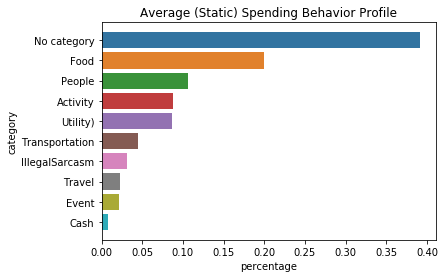

In [116]:
static_behav = static_avg_behav.melt().rename({'variable':'category', 'value':'percentage'}, axis=1)\
               .sort_values('percentage', ascending=False)

static_behav['category'] = ['No category','Food', 'People', 'Activity',
                            'Utility)', 'Transportation', 'IllegalSarcasm', 'Travel','Event','Cash']

sns.barplot(x = 'percentage', y = 'category', data=static_behav)\
   .set(title = "Average (Static) Spending Behavior Profile")

plt.plot()

# Explore how a user’s spending profile is evolving over his/her lifetime (measured measured by months -- taking up to 12 months here)

In [64]:
overCategory = Window.partitionBy("user1")

date_lookup0 = all_user_transactions\
                .withColumn('zero_mark', F.min('datetime').over(overCategory))\
                .withColumn('days_to_zero', F.datediff('datetime','zero_mark'))\
                .withColumn('month', F.ceil(F.column('days_to_zero')/30))\
                .drop('zero_mark', 'days_to_zero')\
                .cache()

In [66]:
# Filter for trasactions that only happens into the first 12 months
venmo_time = date_lookup0\
             .select('user1', 'month', 'category')\
             .repartition(F.col("month"),F.col("category"))\
             .filter('month <= 12').cache()

In [67]:
# Create count of category by user and month
agg_venmo_time = venmo_time\
                .groupBy(['user1', 'month', 'category'])\
                .agg(F.count('category').alias('cat_count'))\
                .repartition(F.col("month"),F.col("category"))\
                .cache()

In [68]:
# Temporary to create Blank Data Frame
users_vec = venmo_time.select('user1').distinct().cache()
months_vec = venmo_time.select('month').distinct().cache()
cat_vec = venmo_time.select('category').distinct().cache()

In [69]:
# Create temporary DF to collect months
blank_venmo_0 = months_vec.crossJoin(cat_vec).repartition(F.col("month"),F.col("category"))
blank_venmo = blank_venmo_0.crossJoin(users_vec).cache()

In [70]:
overCategory = Window.orderBy(['user1','category','month'])\
               .partitionBy("user1",'category')\
               .rowsBetween(Window.unboundedPreceding, Window.currentRow)


big_venmo = blank_venmo\
            .join(agg_venmo_time, on=['user1', 'month', 'category'], how='left_outer')\
            .repartition(F.col("month"),F.col("category"))\
            .withColumn('cum_count', F.sum('cat_count').over(overCategory))\
            .orderBy('user1','category','month')\
            .fillna(0)\
            .cache()

In [71]:
big_venmo.show(15)

+-----+-----+--------------+---------+---------+
|user1|month|      category|cat_count|cum_count|
+-----+-----+--------------+---------+---------+
|    2|    0|      Activity|        0|        0|
|    2|    0|          Cash|        0|        0|
|    2|    0|         Event|        0|        0|
|    2|    0|          Food|        0|        0|
|    2|    0|IllegalSarcasm|        0|        0|
|    2|    0|   No category|        1|        1|
|    2|    0|        People|        0|        0|
|    2|    0|Transportation|        0|        0|
|    2|    0|        Travel|        0|        0|
|    2|    0|       Utility|        0|        0|
|    2|    1|      Activity|        0|        0|
|    2|    1|          Cash|        0|        0|
|    2|    1|         Event|        0|        0|
|    2|    1|          Food|        0|        0|
|    2|    1|IllegalSarcasm|        0|        0|
|    2|    1|   No category|        0|        1|
|    2|    1|        People|        0|        0|
|    2|    1|Transpo

In [72]:
# Calculate category percentage of transations by user and month
overCategory = Window.partitionBy(["user1", "month"])

big_venmo_perc = big_venmo\
                .withColumn("monthly_count",  F.sum("cat_count").over(overCategory))\
                .withColumn("percent_count", F.column("cat_count")/ F.column("monthly_count"))\
                .withColumn("monthly_cum_count",  F.sum("cum_count").over(overCategory))\
                .withColumn("percent_cum_count", F.column("cum_count")/ F.column("monthly_cum_count"))\
                .drop('cat_count','monthly_count', "cum_count", "monthly_cum_count").fillna(0).cache()

In [88]:
# big_venmo_perc.repartition(1).write.mode("overwrite").parquet("big_venmo_perc.parquet")

In [74]:
# Aggregate by month and category: average user
agg_venmo = big_venmo_perc.groupBy(['month', 'category'])\
            .agg(
                 F.round(F.mean('percent_count'),3).alias('mean_percent'), 
                 F.round(F.stddev('percent_count'),3).alias('std_percent'),
                 F.round(F.mean('percent_cum_count'),3).alias('mean_percent_cum'), 
                 F.round(F.stddev('percent_cum_count'),3).alias('std_percent_cum')
                ).cache()

In [75]:
agg_venmo.show(15)

+-----+--------+------------+-----------+----------------+---------------+
|month|category|mean_percent|std_percent|mean_percent_cum|std_percent_cum|
+-----+--------+------------+-----------+----------------+---------------+
|    0|Activity|       0.091|      0.287|           0.091|          0.287|
|    1|Activity|       0.013|      0.109|           0.091|          0.276|
|    2|Activity|       0.011|        0.1|           0.091|          0.268|
|    3|Activity|       0.011|      0.097|            0.09|          0.261|
|    4|Activity|        0.01|      0.096|            0.09|          0.255|
|    5|Activity|        0.01|      0.096|            0.09|          0.249|
|    6|Activity|        0.01|      0.095|           0.089|          0.245|
|    7|Activity|        0.01|      0.094|           0.089|          0.241|
|    8|Activity|        0.01|      0.091|           0.089|          0.237|
|    9|Activity|       0.009|      0.088|           0.089|          0.234|
|   10|Activity|       0.

 After the first use, the average customer will significantly reduce the percentage spend on all categories. Despite not intuitive, this happens because only a fraction of the custmers keeps using Venmo after the first transactions. Since for the churn user the percentage spend on next months are zero, the average moves towards zero. However, as seen on the plots above, this behavior stabilizes from the second month on.

# Find a user’s friends and friends of friends ( Friend definition: A user’s friend is someone who has transacted with the user , either sending money to the user or receiving money from the user).

## Full Lifetime Friends
This section finds a user's list of friends and friends of friends from his/her entire lifetime. There is another section below that shows the user's list of friends by each month of his/her lifetime.

In [0]:
all_transactions = spark.sql("""
  SELECT t1.user1, t1.user2
    FROM user_table1 t1
    UNION
  SELECT t2.user2 as user1, t2.user1 as user2
  FROM user_table1 t2
  """)

In [0]:
# count is less than 14 mil because UNION removes duplicate rows
print(all_transactions.count())

9995562


In [0]:
# gather direct friends into set
friends = all_transactions.groupby('user1').agg(F.collect_set("user2").alias('friend_set'))

In [0]:
all_transactions.createOrReplaceTempView('all_users')

In [0]:
# self join to get friends of friends
joined_users = spark.sql("""
SELECT t1.user1, t2.user2 AS friend_of_friend
FROM all_users t1
FULL OUTER JOIN all_users t2 on t1.user2 = t2.user1""")

In [0]:
# gather friends of friends into set
f_of_f = joined_users.groupby('user1').agg(F.collect_set("friend_of_friend").alias('friend_of_friend'))

In [0]:
friends = friends.cache()
f_of_f = f_of_f.cache()

In [0]:
friends.orderBy('user1').show(10, False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user1|friend_set                                                                                                                                                                                              |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2    |[220, 191142, 43]                                                                                                                                                                                       |
|3    |[52, 1079020, 263437, 43, 567957, 7854140, 2382556, 1204190]                                                                                                 

In [0]:
f_of_f.orderBy('user1').show(10)

+-----+--------------------+
|user1|    friend_of_friend|
+-----+--------------------+
|    2|[49778, 3565, 892...|
|    3|[263468, 277545, ...|
|    4|[114204, 3247825,...|
|    6|[6190225, 1047359...|
|    8|[2734056, 6573431...|
|    9|[2822812, 2667704...|
|   10|[189467, 126820, ...|
|   11|[265225, 5517890,...|
|   12|[459250, 292151, ...|
|   13|[149919, 6419, 26...|
+-----+--------------------+
only showing top 10 rows



In [0]:
# show friends of friends of user 8
row = f_of_f.where(f_of_f.user1 == 8)
row.show(10, False)

+-----+--------------------------------------+
|user1|friend_of_friend                      |
+-----+--------------------------------------+
|8    |[2734056, 6573431, 704469, 1234370, 8]|
+-----+--------------------------------------+



In [0]:
# show direct friends of user 8's 2 direct friends: 900433 and 659067
# output of this should be the same as above
row = friends.where((friends.user1 == 900433) | (friends.user1 == 659067))
row.show(10, False)

+------+-----------------------------+
|user1 |friend_set                   |
+------+-----------------------------+
|659067|[6573431, 8]                 |
|900433|[2734056, 704469, 1234370, 8]|
+------+-----------------------------+



In [0]:
joined_users = joined_users.cache()

In [0]:
# create udf to remove self from friend of friend list
@udf(returnType=ArrayType(IntegerType()))
def remove_user(friend_list,user1):
    filtered_list = [x for x in friend_list if x != user1]
    return filtered_list

In [0]:
# remove self from friend of friend list
f_of_f2 = f_of_f.withColumn("friend_of_friend_adj",remove_user(col("friend_of_friend"),col("user1")))  
f_of_f2 = f_of_f2.cache()

In [0]:
row = f_of_f2.where(f_of_f2.user1 == 8)
row.show(10, False)

+-----+--------------------------------------+-----------------------------------+
|user1|friend_of_friend                      |friend_of_friend_adj               |
+-----+--------------------------------------+-----------------------------------+
|8    |[2734056, 6573431, 704469, 1234370, 8]|[2734056, 6573431, 704469, 1234370]|
+-----+--------------------------------------+-----------------------------------+



In [0]:
f_of_f2 = f_of_f2.drop('friend_of_friend')

In [0]:
friends.createOrReplaceTempView('friends')
f_of_f2.createOrReplaceTempView('f_of_f')

In [0]:
# combine the two new dataframes
final_friends = spark.sql("""
SELECT f1.*, f2.friend_of_friend_adj
FROM friends f1
INNER JOIN f_of_f f2 on f1.user1 = f2.user1""")

In [0]:
final_friends = final_friends.cache()
final_friends.orderBy('user1').show(10)

+-----+--------------------+--------------------+
|user1|          friend_set|friend_of_friend_adj|
+-----+--------------------+--------------------+
|    2|   [220, 191142, 43]|[49778, 3565, 892...|
|    3|[52, 1079020, 263...|[263468, 277545, ...|
|    4|[122744, 9271982,...|[114204, 3247825,...|
|    6|[4330489, 688883,...|[6190225, 1047359...|
|    8|    [900433, 659067]|[2734056, 6573431...|
|    9|[185494, 367955, ...|[2822812, 2667704...|
|   10|[255, 13, 36523, ...|[189467, 126820, ...|
|   11|[149919, 6419, 52...|[265225, 5517890,...|
|   12|[135778, 221813, ...|[459250, 292151, ...|
|   13|[126820, 212813, ...|[149919, 6419, 26...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [0]:
# get the counts of friends and friends of friends
from pyspark.sql.functions import size

friends_with_count = final_friends.select('*',size('friend_set').alias('num_friends'))
friends_with_count = friends_with_count.select('*',size('friend_of_friend_adj').alias('num_f_of_f'))

In [0]:
friends_with_count = friends_with_count.cache()
friends_with_count.orderBy('user1').show(10)

+-----+--------------------+--------------------+-----------+----------+
|user1|          friend_set|friend_of_friend_adj|num_friends|num_f_of_f|
+-----+--------------------+--------------------+-----------+----------+
|    2|   [220, 191142, 43]|[49778, 3565, 892...|          3|        22|
|    3|[52, 1079020, 263...|[263468, 277545, ...|          8|        70|
|    4|[122744, 9271982,...|[114204, 3247825,...|          7|         8|
|    6|[4330489, 688883,...|[6190225, 1047359...|          3|        13|
|    8|    [900433, 659067]|[2734056, 6573431...|          2|         4|
|    9|[185494, 367955, ...|[2822812, 2667704...|          4|        67|
|   10|[255, 13, 36523, ...|[189467, 126820, ...|          7|        45|
|   11|[149919, 6419, 52...|[265225, 5517890,...|         28|       238|
|   12|[135778, 221813, ...|[459250, 292151, ...|          9|        37|
|   13|[126820, 212813, ...|[149919, 6419, 26...|         18|        92|
+-----+--------------------+--------------------+--

## Lifetime by Month Friends

In [0]:
date_lookup = date_lookup0\
             .select('user1', 'user2', 'datetime', F.col('month').alias('month_user1'))\
             .repartition(F.col("month_user1"))\
             .cache()


In [0]:
date_lookup.show()

+------+-------+-------------------+-----------+
| user1|  user2|           datetime|month_user1|
+------+-------+-------------------+-----------+
| 28759| 581923|2015-04-04 06:39:43|         26|
| 65220|  54003|2016-05-22 14:30:05|         26|
| 67492|  47721|2016-02-03 01:38:52|         29|
| 67492|  46611|2016-01-24 19:26:12|         29|
|104064|5428405|2016-01-13 23:13:09|         26|
|109622| 561044|2016-05-07 23:58:32|         26|
|120706|1003952|2016-09-30 00:13:18|         29|
|124861| 167069|2014-09-01 21:51:06|         26|
|124861| 167069|2014-11-24 21:53:44|         29|
|124967| 276840|2016-09-17 18:58:11|         26|
|124967|1743063|2016-09-19 17:43:33|         26|
|126365| 196727|2014-09-14 04:04:18|         26|
|132318| 104220|2016-04-18 18:14:51|         26|
|136625|2872459|2014-11-25 16:33:49|         26|
|139535| 481273|2015-01-01 17:25:18|         29|
|139535| 141775|2015-01-02 19:36:55|         29|
|143737| 388517|2015-03-15 04:04:17|         29|
|143737|3813706|2015

In [0]:
date_lookup.count()

14226274

In [0]:
date_lookup.createOrReplaceTempView('date_lookup')

In [0]:
# self join to get user2's month of the transaction
# because data is stacked with the original user2 column as user1, there will always be a matching row
final_users = spark.sql("""
  SELECT t1.*, t2.month_user1 AS month_user2
    FROM date_lookup t1
    JOIN date_lookup t2 ON t1.user2 = t2.user1
    AND t1.datetime = t2.datetime
  """)

In [0]:
final_users.cache()
final_users.count()

14227514

In [0]:
final_users.orderBy('user1').show()

+-----+-------+-------------------+-----------+-----------+
|user1|  user2|           datetime|month_user1|month_user2|
+-----+-------+-------------------+-----------+-----------+
|    2|     43|2016-09-07 00:53:16|         47|         54|
|    2|    220|2012-11-22 22:03:42|          0|          0|
|    2| 191142|2016-09-26 02:56:55|         47|         17|
|    2|     43|2016-04-09 02:29:31|         42|         49|
|    3|     52|2016-09-22 08:30:09|          3|         51|
|    3|2382556|2016-10-06 03:49:45|          4|          0|
|    3|7854140|2016-10-08 20:36:13|          4|          0|
|    3| 567957|2016-10-29 02:28:07|          5|         32|
|    3|1079020|2016-10-07 16:37:56|          4|          9|
|    3|2382556|2016-10-07 01:50:23|          4|          1|
|    3|     43|2016-06-26 18:14:37|          0|         52|
|    3|1204190|2016-10-08 18:56:24|          4|         24|
|    3| 263437|2016-07-22 14:16:37|          1|         40|
|    4| 187560|2015-06-17 02:23:30|     

In [0]:
# gather friends by user and month to get direct friends
friends = final_users.groupby('user1', 'month_user1').agg(F.collect_set("user2").alias('friend_set')).cache()

In [0]:
friends.orderBy('user1', 'month_user1').show()

+-----+-----------+--------------------+
|user1|month_user1|          friend_set|
+-----+-----------+--------------------+
|    2|          0|               [220]|
|    2|         42|                [43]|
|    2|         47|        [191142, 43]|
|    3|          0|                [43]|
|    3|          1|            [263437]|
|    3|          3|                [52]|
|    3|          4|[1079020, 7854140...|
|    3|          5|            [567957]|
|    4|          0|            [122744]|
|    4|          1|            [125527]|
|    4|          2|            [125755]|
|    4|         15|            [968271]|
|    4|         31|            [187560]|
|    4|         40|           [9271982]|
|    4|         42|            [221578]|
|    6|          0|            [676003]|
|    6|         10|           [4330489]|
|    6|         15|            [676003]|
|    6|         23|            [688883]|
|    8|          0|            [900433]|
+-----+-----------+--------------------+
only showing top

In [0]:
final_users.createOrReplaceTempView('final_users')

In [0]:
# self join to get friends of friends
# join also on month_user1 = month_user2 to only get user2's friends in the same month as the transaction
joined_users = spark.sql("""
SELECT t1.user1, t2.user2 AS friend_of_friend, t1.month_user1
FROM final_users t1
FULL OUTER JOIN final_users t2 on t1.user2 = t2.user1
AND t2.month_user1 = t1.month_user2""")

In [0]:
# gather friends of friends into set
f_of_f = joined_users.groupby('user1', 'month_user1')\
         .agg(F.collect_set("friend_of_friend").alias('friend_of_friend'))

In [0]:
# create udf to remove self from friend of friend list
@udf(returnType=ArrayType(IntegerType()))
def remove_user(friend_list,user1):
    filtered_list = [x for x in friend_list if x != user1]
    return filtered_list

In [0]:
# remove self from friend of friend list  AND limite month_user1 up to 12 months only
f_of_f = f_of_f\
            .withColumn("friend_of_friend_adj",remove_user(col("friend_of_friend"),col("user1")))\
            .filter("month_user1 <= 12")\
            .cache()

In [0]:
f_of_f.orderBy('user1', 'month_user1').show()

+-----+-----------+----------------+--------------------+
|user1|month_user1|friend_of_friend|friend_of_friend_adj|
+-----+-----------+----------------+--------------------+
|    2|          0|             [2]|                  []|
|    3|          0|             [3]|                  []|
|    3|          1|             [3]|                  []|
|    3|          3|             [3]|                  []|
|    3|          4|             [3]|                  []|
|    3|          5|             [3]|                  []|
|    4|          0|             [4]|                  []|
|    4|          1|             [4]|                  []|
|    4|          2|             [4]|                  []|
|    6|          0|             [6]|                  []|
|    6|         10|             [6]|                  []|
|    8|          0|             [8]|                  []|
|    8|          2|    [2734056, 8]|           [2734056]|
|    8|          7|             [8]|                  []|
|    8|       

# Social network variables across a user’s lifetime in Venmo (from 0 up to 12 months).

##  Number of friends and number of friends of friends 

In [0]:
friends.createOrReplaceTempView('friends')
f_of_f.createOrReplaceTempView('f_of_f')

# combine the two new dataframes
final_friends = spark.sql("""
SELECT f1.*, f2.friend_of_friend_adj
FROM friends f1
INNER JOIN f_of_f f2 on f1.user1 = f2.user1
AND f1.month_user1 = f2.month_user1""")

In [0]:
# get the counts of friends and friends of friends
from pyspark.sql.functions import size

friends_with_count = final_friends.select('*',size('friend_set').alias('num_friends'))
friends_with_count = friends_with_count.select('*',size('friend_of_friend_adj').alias('num_f_of_f')).cache()

In [0]:
friends_with_count.orderBy('user1', 'month_user1').show()

+-----+-----------+--------------------+--------------------+-----------+----------+
|user1|month_user1|          friend_set|friend_of_friend_adj|num_friends|num_f_of_f|
+-----+-----------+--------------------+--------------------+-----------+----------+
|    2|          0|               [220]|                  []|          1|         0|
|    3|          0|                [43]|                  []|          1|         0|
|    3|          1|            [263437]|                  []|          1|         0|
|    3|          3|                [52]|                  []|          1|         0|
|    3|          4|[1079020, 7854140...|                  []|          4|         0|
|    3|          5|            [567957]|                  []|          1|         0|
|    4|          0|            [122744]|                  []|          1|         0|
|    4|          1|            [125527]|                  []|          1|         0|
|    4|          2|            [125755]|                  []|    

## Clustering coefficient of a user's network.  

In [0]:
from graphframes import *

In [0]:
vertices = friends_with_count.select(col('user1').alias('id')).distinct()
vertices.count()

3018657

In [0]:
edges = venmo_df.select(col('user1').alias('src'), col('user2').alias('dst'))
edges.count()

7113137

In [0]:
g = GraphFrame(vertices, edges)

In [0]:
triangles = g.triangleCount()

In [0]:
triangles.createOrReplaceTempView('triangles')
friends_with_count.createOrReplaceTempView('friends_with_count')

coeff = spark.sql("""
select t.*, fwc.num_friends
from triangles t join
friends_with_count fwc
on t.id = fwc.user1
""")

In [0]:
@udf(returnType=FloatType())
def cluster_coeff(count,num_friends):
    if(num_friends>1):
        cluster_coefficient = (2*count)/(num_friends*(num_friends-1))
    else:
        cluster_coefficient = None
    return cluster_coefficient

In [0]:
final_coeff = coeff.withColumn("cluster_coefficient",cluster_coeff(col("count"),col("num_friends"))) 

In [0]:
final_coeff.orderBy(desc('cluster_coefficient'),'id').show()

+-----+-------+-----------+-------------------+
|count|     id|num_friends|cluster_coefficient|
+-----+-------+-----------+-------------------+
|  308|1008557|          2|              308.0|
|  308|1008557|          2|              308.0|
|  308|1008557|          2|              308.0|
|  308|1008557|          2|              308.0|
|  225|6124447|          2|              225.0|
|  213| 206476|          2|              213.0|
|  213| 206476|          2|              213.0|
|  213| 206476|          2|              213.0|
|  213| 206476|          2|              213.0|
|  213| 294580|          2|              213.0|
|  208|5579336|          2|              208.0|
|  186|2069464|          2|              186.0|
|  184| 584647|          2|              184.0|
|  184| 584647|          2|              184.0|
|  184| 584647|          2|              184.0|
|  184| 584647|          2|              184.0|
|  184| 584647|          2|              184.0|
|  176|1141808|          2|             

In [0]:
user_and_month = final_users.select(concat_ws(',', col('user1'),col('month_user1')).alias('id')).distinct()

In [0]:
overCategory = Window.partitionBy("user1")

users_w_date = venmo_df.select('user1', 'user2', 'datetime')
users_w_date.createOrReplaceTempView('user_w_date')
users_month = users_w_date\
             .withColumn('zero_mark', F.min('datetime').over(overCategory))\
             .withColumn('days_to_zero', F.datediff('datetime','zero_mark'))\
             .withColumn('month_user1', F.ceil(F.column('days_to_zero')/30))\
             .drop('zero_mark', 'days_to_zero')\
             .repartition(F.col("month_user1"))

switched_users = spark.sql("""
SELECT t2.user2 as user1, t2.user1 as user2, t2.datetime
  FROM user_w_date t2
  """)

switched_users_month = switched_users\
             .withColumn('zero_mark', F.min('datetime').over(overCategory))\
             .withColumn('days_to_zero', F.datediff('datetime','zero_mark'))\
             .withColumn('month_user2', F.ceil(F.column('days_to_zero')/30))\
             .drop('zero_mark', 'days_to_zero')\
             .repartition(F.col("month_user2"))

users_month.createOrReplaceTempView('users_month')
switched_users_month.createOrReplaceTempView('switched_users')

users_all_months = spark.sql("""
SELECT t1.*, t2.month_user2
  FROM users_month t1
  JOIN switched_users t2 ON t1.user2 = t2.user1
  AND t1.datetime = t2.datetime
  """)

edges_w_month = users_all_months.select(concat_ws(',', col('user1'),col('month_user1')).alias('src'),
                                  concat_ws(',', col('user2'), col('month_user2')).alias('dst'))

In [0]:
edges_w_month.show()

+----------+--------+
|       src|     dst|
+----------+--------+
|   72106,0|   43,41|
| 2338707,3|  243,23|
|     43,22|   629,5|
| 652113,23|  747,13|
|1764714,14|  903,16|
| 387953,15| 1162,19|
| 462792,10| 1508,24|
| 279361,37|  2033,0|
| 1532035,0|  3166,7|
| 1674820,0|  3200,1|
| 884057,14|  4205,1|
| 4724583,1|  4541,7|
| 1287799,6| 4885,27|
| 5140673,0|  5145,0|
| 3969230,8|  6213,6|
| 1162566,0| 6645,14|
|  394195,2| 20012,4|
| 1334387,0| 20289,0|
| 872722,25|21436,17|
|2053719,11| 21768,1|
+----------+--------+
only showing top 20 rows



In [0]:
g2 = GraphFrame(user_and_month, edges_w_month)

In [0]:
triangles2 = g2.triangleCount()

In [0]:
friends_month = friends_with_count\
                .select(concat_ws(',', col('user1'), 'month_user1').alias('id'), col('num_friends'))

In [0]:
friends_month.createOrReplaceTempView('friends_month')
triangles2.createOrReplaceTempView('triangles2')

coeff_month = spark.sql("""
select t.*, fm.num_friends
from triangles2 t join
friends_month fm
on t.id = fm.id
""")

In [0]:
final_coeff_month = coeff_month\
                    .withColumn("cluster_coefficient",cluster_coeff(col("count"),col("num_friends")))\
                    .fillna(0)

final_coeff_month.orderBy('id').show()

+-----+----------+-----------+-------------------+
|count|        id|num_friends|cluster_coefficient|
+-----+----------+-----------+-------------------+
|    0|      10,0|          1|                0.0|
|    0|      10,1|          1|                0.0|
|    0|     10,10|          1|                0.0|
|    0|     10,11|          1|                0.0|
|    0|      10,2|          2|                0.0|
|    0|      10,4|          2|                0.0|
|    0|      10,5|          2|                0.0|
|    0|      10,9|          1|                0.0|
|    0| 1000002,0|          1|                0.0|
|    0|10000027,0|          1|                0.0|
|    0|10000054,0|          1|                0.0|
|    0|10000054,4|          1|                0.0|
|    0| 1000006,0|          1|                0.0|
|    0| 1000006,2|          1|                0.0|
|    0| 1000006,9|          1|                0.0|
|    0| 1000007,0|          1|                0.0|
|    0|10000085,0|          1| 

### Create cumulative joined dataset

In [0]:
# Create cumulative friends
windowval = (Window.partitionBy('user1').orderBy('month_user1')
             .rangeBetween(Window.unboundedPreceding, 0))
direct_friends_cumulative = friends_with_count_month\
                            .withColumn('explode_friends', F.explode(F.col('friend_set')))\
                            .withColumn('cumulative_friends', F.collect_set('explode_friends').over(windowval))\
                            .select('user1','month_user1', 'cumulative_friends')
direct_friends_cumulative.orderBy('user1', 'month_user1').show()

In [0]:
# cumulative friends of friends
windowval = (Window.partitionBy('user1').orderBy('month_user1')
             .rangeBetween(Window.unboundedPreceding, 0))
FoF_cumulative = friends_with_count_month\
                            .withColumn('explode_friends', F.explode(F.col('friend_of_friend_adj')))\
                            .withColumn('cumulative_FoF', F.collect_set('explode_friends').over(windowval))\
                            .select('user1','month_user1', 'cumulative_FoF')
FoF_cumulative.orderBy('user1', 'month_user1').show()

In [0]:
# join to months 0-12
from pyspark.sql.types import *
month_num = [0,1,2,3,4,5,6,7,8,9,10,11,12]
months = spark.createDataFrame(month_num, IntegerType()).select(col('value').alias('month_num'))
distinct_users = all_transactions.select('user1').distinct()
months_users = months.crossJoin(distinct_users)
months_users.orderBy('user1', 'month_num').show()
months_users = months_users.select(col('user1').alias('id'), col('month_num'))
direct_friends_cumulative = direct_friends_cumulative.cache()
months_users = months_users.cache()

In [0]:
# get first 12 months of users
direct_friends_cumulative.createOrReplaceTempView('direct_friends_cumulative')
months_users.createOrReplaceTempView('months_users')

In [0]:
direct_friends_cumulative = direct_friends_cumulative.distinct().repartition('month_user1', 'user1')
months_users = months_users.repartition('month_num', 'id')
cumulative_direct_f_month = months_users.join(direct_friends_cumulative, (months_users.month_num ==  direct_friends_cumulative.month_user1) & (months_users.id == direct_friends_cumulative.user1), 'left')\
                            .select('id', 'month_num', 'cumulative_friends')
cumulative_direct_f_month.orderBy('id', 'month_num').show()
# fill na values
partitionWindow = Window.partitionBy('id').orderBy('month_num')
cumulative_direct_f_month2 = cumulative_direct_f_month.withColumn("cumulative_friends", last("cumulative_friends", True).over(partitionWindow))
cumulative_direct_f_month2.orderBy('id', 'month_num').show()
FoF_cumulative = FoF_cumulative.distinct().repartition('month_user1')

# get first 12 months of users
FoF_cumulative.createOrReplaceTempView('FoF_cumulative')
months_users.createOrReplaceTempView('months_users')
# cumulative_FoF_month = spark.sql("""
# SELECT f2.user1, f1.month_num, f2.cumulative_FoF
# FROM months_users f1
# LEFT JOIN FoF_cumulative f2 ON f1.month_num=f2.month_user1
# """)

In [0]:
cumulative_FoF_month = months_users\
                      .join(FoF_cumulative,
                            (months_users.month_num ==  FoF_cumulative.month_user1) & (months_users.id == FoF_cumulative.user1),
                            'left')\
                      .select('id', 'month_num', 'cumulative_FoF')

cumulative_FoF_month.orderBy('id', 'month_num').show()



In [0]:
# fill na values
partitionWindow = Window.partitionBy('id').orderBy('month_num')
cumulative_FoF_month2 = cumulative_FoF_month.withColumn("cumulative_FoF", last("cumulative_FoF", True).over(partitionWindow))
cumulative_FoF_month2.orderBy('id', 'month_num').show()
cumulative_joined = cumulative_direct_f_month2.join(cumulative_FoF_month2, 
                                                   (cumulative_direct_f_month2.id == cumulative_FoF_month2.user1) & (cumulative_direct_f_month2.month_num == cumulative_FoF_month2.month_num))\
                    .select('*',size('cumulative_friends').alias('num_friends'),
                           size('cumulative_FoF').alias('num_FoF'))

In [0]:
#cumulative_joined.repartition(1).write.mode("overwrite").parquet("cumulative_joined.parquet")

### Cumulative Clustering Coefficient

In [0]:
cumulative_joined = sql_context.read.parquet('cumulative_joined.parquet')

In [0]:
@udf(returnType=FloatType())
def cluster_coeff(count,num_friends):
    if(num_friends>1):
        cluster_coefficient = (2*count)/(num_friends*(num_friends-1))
    else:
        cluster_coefficient = None
    return cluster_coefficient

In [0]:
users_all_months.createOrReplaceTempView('edges_w_month')
# union to get all user transactions regardless of user1 to user2 or user2 to user1
all_user_transactions = spark.sql("""
  SELECT t1.user1, t1.user2, t1.month_user1
    FROM edges_w_month t1
    UNION ALL
  SELECT t2.user2 as user1, t2.user1 as user2, t2.month_user2
  FROM edges_w_month t2
  """)

In [0]:
def cumulative_coefficient(month:int):
    user_and_month = all_user_transactions.select(concat_ws(',', col('user1'),col('month_user1')).alias('id'), col('month_user1'))\
                            .where(col('month_user1') <= month).distinct()
    edges_w_month = users_all_months.select(concat_ws(',', col('user1'),col('month_user1')).alias('src'),
                                  concat_ws(',', col('user2'), col('month_user2')).alias('dst'),
                                       col('month_user1')).where(col('month_user1') <= month)
    graph = GraphFrame(user_and_month, edges_w_month)
    triangles = graph.triangleCount()
    friends_month = cumulative_joined.select(concat_ws(',', col('user1'), 'month_num').alias('id'), col('num_friends'), col('month_num'))
    friends_month.createOrReplaceTempView('friends_month')
    triangles.createOrReplaceTempView('triangles')
    coeff_month = spark.sql("""
    select t.*, fm.num_friends, fm.month_num
    from triangles t join
    friends_month fm
    on t.id = fm.id
    """)
    final_coeff_month = coeff_month.withColumn("cluster_coefficient",cluster_coeff(col("count"),col("num_friends")))
    return final_coeff_month

In [0]:
final_coefficients = cumulative_coefficient(0)
for month in range(1,13):
    month_coefficients = cumulative_coefficient(month)
    
    month_coefficients.createOrReplaceTempView('month_coefficients')
    final_coefficients.createOrReplaceTempView('final_coefficients')
    
    final_coefficients = spark.sql("""
    SELECT *
    from final_coefficients f 
    UNION
    SELECT * FROM month_coefficients m
    """)
    

In [0]:
#final_coefficients.repartition(1).write.mode("overwrite").parquet("clustering_coeff.parquet")
final_coefficients = spark.read.parquet("clustering_coeff.parquet")

In [0]:
final_coefficients = final_coefficients.fillna(0)
final_coefficients.show(10)

+-----+----------+-----------+-----------+---------+-------------------+
|count|        id|month_user1|num_friends|month_num|cluster_coefficient|
+-----+----------+-----------+-----------+---------+-------------------+
|    0| 1028723,0|          0|          1|        0|                0.0|
|    0|13035623,0|          0|          1|        0|                0.0|
|    0| 1320739,0|          0|          1|        0|                0.0|
|    0|13306080,0|          0|          1|        0|                0.0|
|    0| 1491934,0|          0|          1|        0|                0.0|
|    0|  150870,0|          0|          1|        0|                0.0|
|    0| 1520490,0|          0|          1|        0|                0.0|
|    0| 1587599,0|          0|          1|        0|                0.0|
|    0| 1880927,0|          0|          1|        0|                0.0|
|    0| 1956228,0|          0|          1|        0|                0.0|
+-----+----------+-----------+-----------+---------

## Page rank of each user (page rank is a global social network metric)

In [0]:
venmo_df.select("user1", "user2", "datetime").createOrReplaceTempView('venmotable')

In [0]:
pre_stack_df = venmo_df.select('user1', 'user2', 'datetime')
pre_stack_df.createOrReplaceTempView('user_table1')

# union to get all user transactions regardless of user1 to user2 or user2 to user1
all_user_transactions = spark.sql("""
  SELECT t1.user1, t1.user2, t1.datetime
    FROM user_table1 t1
    UNION ALL
  SELECT t2.user2 as user1, t2.user1 as user2, t2.datetime
  FROM user_table1 t2
  """)

In [0]:
overCategory = Window.partitionBy("user1")

monthly_df = all_user_transactions\
            .withColumn('zero_mark', F.min('datetime').over(overCategory))\
            .withColumn('days_to_zero', F.datediff('datetime','zero_mark'))\
            .withColumn('month', F.ceil(F.column('days_to_zero')/30))\
            .drop('days_to_zero', 'user2', 'zero_mark')\
            .withColumn('id', expr("concat(user1, '_', month)"))\
            .cache()

In [0]:
vertices2 = monthly_df.groupBy("id", "user1", "month").count().drop("count").cache()

In [0]:
monthly_df.createOrReplaceTempView('usermonth')

In [0]:
venmo_usermonth = spark.sql("""
select v.user1, v.datetime, um.id as id1, v.user2, um2.id as id2
from venmotable v
left join usermonth um on v.user1 = um.user1 and v.datetime = um.datetime
left join usermonth um2 on v.user2 = um2.user1 and v.datetime = um2.datetime
""").cache()

In [0]:
edges2 = venmo_usermonth.select(F.col("id1").alias("src"),
                                F.col("id2").alias("dst")).cache()

In [0]:
g2 = GraphFrame(vertices2, edges2).persist()

In [0]:
pr2 = g2.pageRank(resetProbability=0.15, maxIter = 20)

In [0]:
# Temporary to create Blank Data Frame
users_vec2 = vertices2.select('user1').distinct().repartition('user1')
months_vec2 = vertices2.select('month').distinct().repartition('month')

blank_pagerank = users_vec2.crossJoin(months_vec2)\
                .cache()

In [0]:
semi_pagerank = blank_pagerank.join(pr2.vertices, on=['user1', 'month'], how='left_outer').cache()

In [0]:
monthly_pagerank = semi_pagerank.drop("id").fillna(0)

In [0]:
#monthly_pagerank.repartition(1).write.mode("overwrite").parquet("monthlypagerank.parquet")
monthly_pagerank = spark.read.parquet("monthlypagerank.parquet")

In [0]:
monthly_pagerank.show(10)

+-----+-----+------------------+
|user1|month|          pagerank|
+-----+-----+------------------+
|    2|   51|               0.0|
|   11|   35|1.1555082964754304|
|   12|   26|               0.0|
|   13|   18|0.6245990791759084|
|   13|   22|               0.0|
|   16|   22|               0.0|
|   18|    9|               0.0|
|   24|   53|               0.0|
|   42|   17|               0.0|
|   52|   15|               0.0|
+-----+-----+------------------+
only showing top 10 rows



# Machine Learning to explore previously created features. Dependent variable Y , i.e. the total number of transactions at lifetime point 12. In other words, for every user, you need to count how many transactions s/he had committed during her/his twelve months.

In [83]:
venmo_df.createOrReplaceTempView("venmo_df")

venmo_full = spark.sql("""
          select user1 as user, transaction_type, datetime, description, is_business, story_id from venmo_df
          union all
          select user2 as user, transaction_type, datetime, description, is_business, story_id from venmo_df
          """)

In [98]:
window_user = Window.partitionBy("user").orderBy('datetime')
user_lifetime = venmo_full.withColumn('zero_mark', F.min('datetime').over(window_user))\
                          .withColumn('days_to_zero', F.datediff('datetime','zero_mark'))\
                          .withColumn('month', F.ceil(F.column('days_to_zero')/30))\
                          .drop('zero_mark', 'description', 'is_business', 'story_id', 'transaction_type')\
                          .orderBy('user','month','datetime')\
                          .filter('month <= 12')

In [86]:
# Create total number of transactions during users' 12 months in Venmo
Y = user_lifetime.groupBy('user').count()

In [87]:
Y.orderBy('user').show()

+----+-----+
|user|count|
+----+-----+
|   2|    1|
|   3|    9|
|   4|    4|
|   6|    2|
|   8|    6|
|   9|    5|
|  10|   12|
|  11|   13|
|  12|    5|
|  13|    5|
|  16|    7|
|  18|    1|
|  19|    2|
|  24|    2|
|  28|    2|
|  29|    2|
|  31|    1|
|  32|    1|
|  34|    5|
|  42|    5|
+----+-----+
only showing top 20 rows



## RFM (without M)

Create the recency and frequency variables. In CRM, this predictive framework is known as RFM. Here, you don’t have monetary amounts, so we will focus on just RF. Recency refers to the last time a user was active, and frequency is how often a user uses Venmo in a month. You need to compute these metrics across a user’s lifetime in Venmo (from 0 up to 12). 

In [99]:
user_lifetime = user_lifetime.withColumn('txns', count('datetime').over(window_user))\
                             .orderBy('user','month')

In [100]:
temp = user_lifetime.groupBy('user','month').agg(max('datetime').alias('lastst')).orderBy('user','month')

cond = [temp.user == user_lifetime.user, temp.lastst == user_lifetime.datetime]
user_lifetime = temp.join(user_lifetime, cond, 'left_outer')\
                   .select(user_lifetime.user,user_lifetime.month,'days_to_zero','txns')\
                   .orderBy(user_lifetime.user,user_lifetime.month)

In [101]:
# create lifetime view for each user
month = [0,1,2,3,4,5,6,7,8,9,10,11,12]
user_months = Y.withColumn("lifetime", F.array([F.lit(x) for x in month]))\
               .withColumn("lifetime", F.explode(col("lifetime")))\
               .withColumn('lifetime_days', 30*F.col('lifetime'))\
               .withColumnRenamed('count','Y').orderBy('user','lifetime')

In [102]:
user_months.show()

+----+---+--------+-------------+
|user|  Y|lifetime|lifetime_days|
+----+---+--------+-------------+
|   2|  1|       0|            0|
|   2|  1|       1|           30|
|   2|  1|       2|           60|
|   2|  1|       3|           90|
|   2|  1|       4|          120|
|   2|  1|       5|          150|
|   2|  1|       6|          180|
|   2|  1|       7|          210|
|   2|  1|       8|          240|
|   2|  1|       9|          270|
|   2|  1|      10|          300|
|   2|  1|      11|          330|
|   2|  1|      12|          360|
|   3|  9|       0|            0|
|   3|  9|       1|           30|
|   3|  9|       2|           60|
|   3|  9|       3|           90|
|   3|  9|       4|          120|
|   3|  9|       5|          150|
|   3|  9|       6|          180|
+----+---+--------+-------------+
only showing top 20 rows



In [103]:
cond = [user_months.user == user_lifetime.user, user_months.lifetime == user_lifetime.month]
df_rf = user_months.join(user_lifetime, cond, 'left_outer')\
                   .select(user_months.user,user_months.lifetime,'lifetime_days','days_to_zero','txns','Y')\
                   .orderBy(user_months.user,user_months.lifetime)

In [104]:
df_rf.createOrReplaceTempView('df_rf')
rf_full = spark.sql("""
                      SELECT user, lifetime, Y,
                            (SUM(txns)
                             OVER (partition by user 
                                   order by lifetime asc
                                   range between unbounded preceding and current row))/lifetime_days as frequency,
                            (lifetime_days - max(days_to_zero) OVER (partition by user order by lifetime asc)
                             ) as recency
                      FROM df_rf
                      ORDER BY user, lifetime
          """)

In [105]:
# make frequency @t0 = 1;
rf_full = rf_full.fillna(1)

In [106]:
rf_full.show()

+----+--------+---+--------------------+-------+
|user|lifetime|  Y|           frequency|recency|
+----+--------+---+--------------------+-------+
|   2|       0|  1|                 1.0|      0|
|   2|       1|  1| 0.03333333333333333|     30|
|   2|       2|  1|0.016666666666666666|     60|
|   2|       3|  1|0.011111111111111112|     90|
|   2|       4|  1|0.008333333333333333|    120|
|   2|       5|  1|0.006666666666666667|    150|
|   2|       6|  1|0.005555555555555556|    180|
|   2|       7|  1|0.004761904761904762|    210|
|   2|       8|  1|0.004166666666666667|    240|
|   2|       9|  1|0.003703703703703704|    270|
|   2|      10|  1|0.003333333333333...|    300|
|   2|      11|  1|0.003030303030303...|    330|
|   2|      12|  1|0.002777777777777778|    360|
|   3|       0|  9|                 1.0|      0|
|   3|       1|  9|                 0.1|      4|
|   3|       2|  9|                0.05|     34|
|   3|       3|  9| 0.06666666666666667|      2|
|   3|       4|  9| 

## Regress recency and frequency on Y. 

In [0]:
def get_MSE_1(input_df):
    Assembler = VectorAssembler(inputCols = ['frequency', 'recency'], 
                                outputCol ='features')
    output = Assembler.transform(input_df)
    finalData = output.select('features','Y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='Y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
input_t0 = rf_full.filter('lifetime=0')
input_t1 = rf_full.filter('lifetime=1')
input_t2 = rf_full.filter('lifetime=2')
input_t3 = rf_full.filter('lifetime=3')
input_t4 = rf_full.filter('lifetime=4')
input_t5 = rf_full.filter('lifetime=5')
input_t6 = rf_full.filter('lifetime=6')
input_t7 = rf_full.filter('lifetime=7')
input_t8 = rf_full.filter('lifetime=8')
input_t9 = rf_full.filter('lifetime=9')
input_t10 = rf_full.filter('lifetime=10')
input_t11 = rf_full.filter('lifetime=11')
input_t12 = rf_full.filter('lifetime=12')

In [0]:
MSE_time0 = get_MSE_1(input_t0)
MSE_time1 = get_MSE_1(input_t1)
MSE_time2 = get_MSE_1(input_t2)
MSE_time3 = get_MSE_1(input_t3)
MSE_time4 = get_MSE_1(input_t4)
MSE_time5 = get_MSE_1(input_t5)
MSE_time6 = get_MSE_1(input_t6)
MSE_time7 = get_MSE_1(input_t7)
MSE_time8 = get_MSE_1(input_t8)
MSE_time9 = get_MSE_1(input_t9)
MSE_time10 = get_MSE_1(input_t10)
MSE_time11 = get_MSE_1(input_t11)
MSE_time12 = get_MSE_1(input_t12)

In [0]:
print("MSE @ t0 is", MSE_time0)
print("MSE @ t1 is", MSE_time1)
print("MSE @ t2 is", MSE_time2)
print("MSE @ t3 is", MSE_time3)
print("MSE @ t4 is", MSE_time4)
print("MSE @ t5 is", MSE_time5)
print("MSE @ t6 is", MSE_time6)
print("MSE @ t7 is", MSE_time7)
print("MSE @ t8 is", MSE_time8)
print("MSE @ t9 is", MSE_time9)
print("MSE @ t10 is", MSE_time10)
print("MSE @ t11 is", MSE_time11)
print("MSE @ t12 is", MSE_time12)

In [0]:
lifetime = list(range(13))
MSE1 = [MSE_time0, MSE_time1, MSE_time2, MSE_time3, MSE_time4, MSE_time5, MSE_time6, 
            MSE_time7, MSE_time8, MSE_time9, MSE_time10, MSE_time11, MSE_time12]

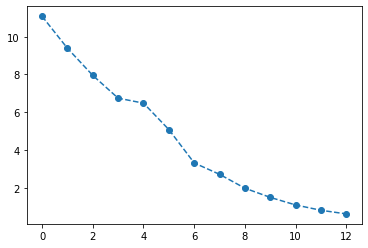

In [0]:
plt.plot(lifetime, MSE1, linestyle='--', marker='o')
plt.show()

## Regress recency, frequency AND spending behavior profile on Y. 

In [107]:
spending = spark.read.parquet("big_venmo_perc.parquet")

In [108]:
spending_wide = spending.repartition('user1', 'month')\
                        .groupBy('user1','month').pivot('category').sum('percent_cum_count')

In [109]:
cond = [rf_full.user == spending_wide.user1, rf_full.lifetime == spending_wide.month]
rf_sp_full = rf_full.join(spending_wide, cond, 'inner')\
                   .drop('user1','month')\
                   .orderBy(rf_full.user,rf_full.lifetime)

In [111]:
rf_sp_full = rf_sp_full.withColumnRenamed('No category','NoCategory')
#rf_sp_full.write.format("parquet").mode("append").save("rf_sp_full.parquet")

In [0]:
def get_MSE_2(input_df):
    Assembler = VectorAssembler(inputCols = ['frequency', 'recency','Activity','Cash','Utility','Nocategory',
                                             'Event','People','Travel','Food','Transportation','IllegalSarcasm'], 
                                outputCol ='features')
    output = Assembler.transform(input_df)
    finalData = output.select('features','Y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='Y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
input_t0 = rf_sp_full.filter('lifetime=0')
input_t1 = rf_sp_full.filter('lifetime=1')
input_t2 = rf_sp_full.filter('lifetime=2')
input_t3 = rf_sp_full.filter('lifetime=3')
input_t4 = rf_sp_full.filter('lifetime=4')
input_t5 = rf_sp_full.filter('lifetime=5')
input_t6 = rf_sp_full.filter('lifetime=6')
input_t7 = rf_sp_full.filter('lifetime=7')
input_t8 = rf_sp_full.filter('lifetime=8')
input_t9 = rf_sp_full.filter('lifetime=9')
input_t10 = rf_sp_full.filter('lifetime=10')
input_t11 = rf_sp_full.filter('lifetime=11')
input_t12 = rf_sp_full.filter('lifetime=12')

In [0]:
MSE2_time0 = get_MSE_2(input_t0)
MSE2_time1 = get_MSE_2(input_t1)
MSE2_time2 = get_MSE_2(input_t2)
MSE2_time3 = get_MSE_2(input_t3)
MSE2_time4 = get_MSE_2(input_t4)
MSE2_time5 = get_MSE_2(input_t5)
MSE2_time6 = get_MSE_2(input_t6)
MSE2_time7 = get_MSE_2(input_t7)
MSE2_time8 = get_MSE_2(input_t8)
MSE2_time9 = get_MSE_2(input_t9)
MSE2_time10 = get_MSE_2(input_t10)
MSE2_time11 = get_MSE_2(input_t11)
MSE2_time12 = get_MSE_2(input_t12)

In [0]:
print("MSE @ t0 is", MSE2_time0)
print("MSE @ t1 is", MSE2_time1)
print("MSE @ t2 is", MSE2_time2)
print("MSE @ t3 is", MSE2_time3)
print("MSE @ t4 is", MSE2_time4)
print("MSE @ t5 is", MSE2_time5)
print("MSE @ t6 is", MSE2_time6)
print("MSE @ t7 is", MSE2_time7)
print("MSE @ t8 is", MSE2_time8)
print("MSE @ t9 is", MSE2_time9)
print("MSE @ t10 is", MSE2_time10)
print("MSE @ t11 is", MSE2_time11)
print("MSE @ t12 is", MSE2_time12)

MSE @ t0 is 11.289736026643006
MSE @ t1 is 9.006524569394738
MSE @ t2 is 9.469714043591884
MSE @ t3 is 6.2907732963499425
MSE @ t4 is 5.175139878867147
MSE @ t5 is 4.520511494761269
MSE @ t6 is 3.8845700145384403
MSE @ t7 is 2.607995750483481
MSE @ t8 is 2.1864600656867457
MSE @ t9 is 1.4848176537421047
MSE @ t10 is 1.0726926836351536
MSE @ t11 is 0.8132600065263095
MSE @ t12 is 0.7813836450280583


In [0]:
lifetime = list(range(13))
MSE2 = [MSE2_time0, MSE2_time1, MSE2_time2, MSE2_time3, MSE2_time4, MSE2_time5, MSE2_time6, 
            MSE2_time7, MSE2_time8, MSE2_time9, MSE2_time10, MSE2_time11, MSE2_time12]

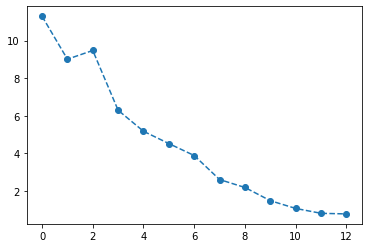

In [0]:
import matplotlib.pyplot as plt
plt.plot(lifetime, MSE2, linestyle='--', marker='o')
plt.show()

## Regress social network metrics on Y. 

In [84]:
pr = spark.read.parquet("monthlypagerank.parquet")

In [126]:
clustering = spark.read.parquet("clustering_coeff.parquet")

In [127]:
clustering = clustering.select('*', F.split('id', ',').alias('id_fix'))

In [128]:
clustering = clustering.withColumn('user', clustering["id_fix"].getItem(0))

In [133]:
clustering = clustering.select('user','month_num','cluster_coefficient')

In [95]:
network = spark.read.parquet("cumulative_joined.parquet")

In [98]:
network = network.withColumn('fixed_num_FoF',when(network.num_FoF == -1,0)\
                 .otherwise(network.num_FoF))

In [101]:
network = network.select('user1','month','num_friends','fixed_num_FOF')

In [115]:
# join network and pr
cond = [pr.user1 == network.user1, pr.month == network.month]
net_pr = pr.join(network, cond, 'inner')\
           .drop(pr.user1)\
           .drop(pr.month)\
           .orderBy(network.user1,network.month)

In [135]:
# join network+pr and clustering coeff
cond = [net_pr.user1 == clustering.user, net_pr.month == clustering.month_num]
social_all = net_pr.join(clustering, cond, 'inner')\
                   .drop(net_pr.user1)\
                   .drop(clustering.month_num)\
                   .orderBy(clustering.user,net_pr.month)

In [145]:
cond = [social_all.user == user_months.user, social_all.month == user_months.lifetime]
df_social = social_all.join(user_months, cond, 'inner')\
                      .drop(social_all.user)\
                      .drop(social_all.month)\
                      .drop('lifetime_days')\
                      .orderBy(user_months.user,user_months.lifetime)

In [165]:
df_social = df_social.fillna(0)

In [151]:
# df_social.coalesce(1).write.format("parquet").mode("append").save("df_social.parquet")

In [112]:
df_social = spark.read.parquet("df_social.parquet") 

df_social = df_social.fillna(0)

In [0]:
def get_MSE_3(input_df):
    Assembler = VectorAssembler(inputCols = ['pagerank','num_friends','fixed_num_FOF',
                                             'cluster_coefficient'], 
                                outputCol ='features')
    output = Assembler.transform(input_df)
    finalData = output.select('features','Y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='Y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
input_t0 = df_social.filter('lifetime=0')
input_t1 = df_social.filter('lifetime=1')
input_t2 = df_social.filter('lifetime=2')
input_t3 = df_social.filter('lifetime=3')
input_t4 = df_social.filter('lifetime=4')
input_t5 = df_social.filter('lifetime=5')
input_t6 = df_social.filter('lifetime=6')
input_t7 = df_social.filter('lifetime=7')
input_t8 = df_social.filter('lifetime=8')
input_t9 = df_social.filter('lifetime=9')
input_t10 = df_social.filter('lifetime=10')
input_t11 = df_social.filter('lifetime=11')
input_t12 = df_social.filter('lifetime=12')

In [0]:
MSE3_time0 = get_MSE_3(input_t0)
MSE3_time1 = get_MSE_3(input_t1)
MSE3_time2 = get_MSE_3(input_t2)
MSE3_time3 = get_MSE_3(input_t3)
MSE3_time4 = get_MSE_3(input_t4)
MSE3_time5 = get_MSE_3(input_t5)
MSE3_time6 = get_MSE_3(input_t6)
MSE3_time7 = get_MSE_3(input_t7)
MSE3_time8 = get_MSE_3(input_t8)
MSE3_time9 = get_MSE_3(input_t9)
MSE3_time10 = get_MSE_3(input_t10)
MSE3_time11 = get_MSE_3(input_t11)
MSE3_time12 = get_MSE_3(input_t12)

In [0]:
print("MSE @ t0 is", MSE3_time0)
print("MSE @ t1 is", MSE3_time1)
print("MSE @ t2 is", MSE3_time2)
print("MSE @ t3 is", MSE3_time3)
print("MSE @ t4 is", MSE3_time4)
print("MSE @ t5 is", MSE3_time5)
print("MSE @ t6 is", MSE3_time6)
print("MSE @ t7 is", MSE3_time7)
print("MSE @ t8 is", MSE3_time8)
print("MSE @ t9 is", MSE3_time9)
print("MSE @ t10 is", MSE3_time10)
print("MSE @ t11 is", MSE3_time11)
print("MSE @ t12 is", MSE3_time12)

MSE @ t0 is 11.701516539340895
MSE @ t1 is 20.206115141467464
MSE @ t2 is 18.330550836085987
MSE @ t3 is 32.54654906063732
MSE @ t4 is 27.558231797251377
MSE @ t5 is 14.870278761634086
MSE @ t6 is 12.920858117284231
MSE @ t7 is 11.819682388320887
MSE @ t8 is 10.414562721451961
MSE @ t9 is 9.692955732304517
MSE @ t10 is 9.531680850689071
MSE @ t11 is 8.250317846162268
MSE @ t12 is 7.638408557391968


In [0]:
lifetime = list(range(13))
MSE3 = [MSE3_time0, MSE3_time1, MSE3_time2, MSE3_time3, MSE3_time4, MSE3_time5, MSE3_time6, 
            MSE3_time7, MSE3_time8, MSE3_time9, MSE3_time10, MSE3_time11, MSE3_time12]

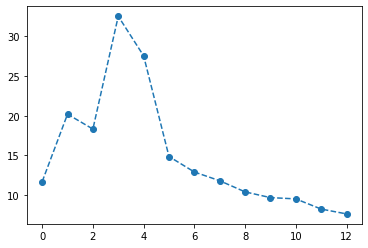

In [0]:
plt.plot(lifetime, MSE3, linestyle='--', marker='o')
plt.show()

In [193]:
Assembler = VectorAssembler(inputCols = ['pagerank','num_friends','fixed_num_FOF',
                                         'cluster_coefficient'], 
                            outputCol ='features')
output = Assembler.transform(input_t12)
finalData = output.select('features','Y')
trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
lrModel = LinearRegression(labelCol ='Y', featuresCol='features')
lrEstimator = lrModel.fit(trainData)
testResults = lrEstimator.evaluate(testData)
rmse = testResults.rootMeanSquaredError
mse = rmse**2

In [194]:
print("Coefficients: %s" % str(lrEstimator.coefficients))
print("Intercept: %s" % str(lrEstimator.intercept))

Coefficients: [0.4999187195412696,1.2900766933361676,0.014595757470569043,7.8595257242997105]
Intercept: 0.3952873820633144


In [200]:
features = ['pagerank','num_friends','fixed_num_FOF','cluster_coefficient']

In [201]:
coeff = [0.4999187195412696,1.2900766933361676,0.014595757470569043,7.8595257242997105]

In [202]:
df_dict = {'Features':features,'coeff':coeff}

In [203]:
summary_tbl = pd.DataFrame(df_dict)

In [204]:
summary_tbl

,Features,coeff
0,pagerank,0.499919
1,num_friends,1.290077
2,fixed_num_FOF,0.014596
3,cluster_coefficient,7.859526


# Question 12
For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plot the MSE for each lifetime point like above. Does the spending behavior of her social network add any predictive benefit compared to Q10?

In [0]:
rf_sp_full = spark.read.parquet("rf_sp_full.parquet")

In [0]:
# join social, RF and spending behaviors
cond = [rf_sp_full.user == df_social.user, rf_sp_full.lifetime == df_social.month]
df_full = rf_sp_full.join(df_social, cond, 'inner')\
                    .drop(df_social.user)\
                    .drop(df_social.month)\
                    .orderBy(rf_sp_full.user,rf_sp_full.lifetime)

In [0]:
def get_MSE_4(input_df):
    Assembler = VectorAssembler(inputCols = ['frequency','recency','Activity','Cash','Event',
                                             'Food','IllegalSarcasm','NoCategory','People','Tavel',
                                             'Transportation','Travel','Utility','pagerank','num_friends',
                                             'fixed_num_FOF','cluster_coefficient'], 
                                outputCol ='features')
    output = Assembler.transform(input_df)
    finalData = output.select('features','Y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='Y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
input_t0 = df_full.filter('lifetime=0')
input_t1 = df_full.filter('lifetime=1')
input_t2 = df_full.filter('lifetime=2')
input_t3 = df_full.filter('lifetime=3')
input_t4 = df_full.filter('lifetime=4')
input_t5 = df_full.filter('lifetime=5')
input_t6 = df_full.filter('lifetime=6')
input_t7 = df_full.filter('lifetime=7')
input_t8 = df_full.filter('lifetime=8')
input_t9 = df_full.filter('lifetime=9')
input_t10 = df_full.filter('lifetime=10')
input_t11 = df_full.filter('lifetime=11')
input_t12 = df_full.filter('lifetime=12')

In [0]:
MSE4_time0 = get_MSE_4(input_t0)
MSE4_time1 = get_MSE_4(input_t1)
MSE4_time2 = get_MSE_4(input_t2)
MSE4_time3 = get_MSE_4(input_t3)
MSE4_time4 = get_MSE_4(input_t4)
MSE4_time5 = get_MSE_4(input_t5)
MSE4_time6 = get_MSE_4(input_t6)
MSE4_time7 = get_MSE_4(input_t7)
MSE4_time8 = get_MSE_4(input_t8)
MSE4_time9 = get_MSE_4(input_t9)
MSE4_time10 = get_MSE_4(input_t10)
MSE4_time11 = get_MSE_4(input_t11)
MSE4_time12 = get_MSE_4(input_t12)

In [0]:
print("MSE @ t0 is", MSE4_time0)
print("MSE @ t1 is", MSE4_time1)
print("MSE @ t2 is", MSE4_time2)
print("MSE @ t3 is", MSE4_time3)
print("MSE @ t4 is", MSE4_time4)
print("MSE @ t5 is", MSE4_time5)
print("MSE @ t6 is", MSE4_time6)
print("MSE @ t7 is", MSE4_time7)
print("MSE @ t8 is", MSE4_time8)
print("MSE @ t9 is", MSE4_time9)
print("MSE @ t10 is", MSE4_time10)
print("MSE @ t11 is", MSE4_time11)
print("MSE @ t12 is", MSE4_time12)

MSE @ t0 is 11.548008947523108
MSE @ t1 is 18.580371042904886
MSE @ t2 is 17.643388566188655
MSE @ t3 is 16.420270800658425
MSE @ t4 is 26.026324323641532
MSE @ t5 is 15.41261516265958
MSE @ t6 is 10.391185386714264
MSE @ t7 is 8.348191511363801
MSE @ t8 is 6.664149156898889
MSE @ t9 is 4.917973666699491
MSE @ t10 is 3.6027476075352385
MSE @ t11 is 2.3167910144771255
MSE @ t12 is 1.341706587596756


In [0]:
lifetime = list(range(13))
MSE4 = [MSE4_time0, MSE4_time1, MSE4_time2, MSE4_time3, MSE4_time4, MSE4_time5, MSE4_time6, 
            MSE4_time7, MSE4_time8, MSE4_time9, MSE4_time10, MSE4_time11, MSE4_time12]

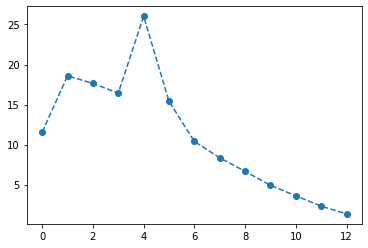

In [0]:
plt.plot(lifetime, MSE4, linestyle='--', marker='o')
plt.show()

In [0]:
# df_full.coalesce(1).write.format("parquet").mode("append").save("df_full.parquet")

In [186]:
Assembler = VectorAssembler(inputCols = ['frequency','recency','Activity','Cash','Event',
                                         'Food','IllegalSarcasm','NoCategory','People','Tavel',
                                         'Transportation','Travel','Utility','pagerank','num_friends',
                                         'fixed_num_FOF','cluster_coefficient'], 
                            outputCol ='features')
output = Assembler.transform(input_t12)
finalData = output.select('features','Y')
trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
lrModel = LinearRegression(labelCol ='Y', featuresCol='features')
lrEstimator = lrModel.fit(trainData)

In [189]:
print("Coefficients: %s" % str(lrEstimator.coefficients))
print("Intercept: %s" % str(lrEstimator.intercept))

Coefficients: [49.697236028356954,-0.002868134938305665,-0.381147925194434,-0.005100596323035913,-0.24657168390409845,0.09249596572117189,-0.18744501819037032,0.024631364656947735,-0.1429097637967972,0.010647729326336862,0.07919640557246171,-0.3096920570097837,0.34370834527757765,-0.0011620403376497576,0.3461376182616857,0.00118139057102735,3.048008555530384]
Intercept: 2.021461612198929


In [195]:
features = ['frequency','recency','Activity','Cash','Event',
                                         'Food','IllegalSarcasm','NoCategory','People','Tavel',
                                         'Transportation','Travel','Utility','pagerank','num_friends',
                                         'fixed_num_FOF','cluster_coefficient']

In [196]:
coeff = [49.697236028356954,-0.002868134938305665,-0.381147925194434,
         -0.005100596323035913,-0.24657168390409845,0.09249596572117189,
         -0.18744501819037032,0.024631364656947735,-0.1429097637967972,0.010647729326336862,
         0.07919640557246171,-0.3096920570097837,0.34370834527757765,-0.0011620403376497576,
         0.3461376182616857,0.00118139057102735,3.048008555530384]

In [197]:
df_dict = {'Features':features,'coeff':coeff}

In [198]:
summary_tbl = pd.DataFrame(df_dict)

In [199]:
summary_tbl

,Features,coeff
0,frequency,49.697236
1,recency,-0.002868
2,Activity,-0.381148
3,Cash,-0.005101
4,Event,-0.246572
5,Food,0.092496
6,IllegalSarcasm,-0.187445
7,NoCategory,0.024631
8,People,-0.142910
9,Tavel,0.010648
